In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6
import warnings
warnings.filterwarnings('ignore')
import seaborn as sb
import pandas.api.types as ptypes

In [2]:
# read file
data = pd.read_csv('data/daily-min-temperatures.csv')
data.head()

,Date,Temp
0,1981-01-01,20.7
1,1981-01-02,17.9
2,1981-01-03,18.8
3,1981-01-04,14.6
4,1981-01-05,15.8


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3650 entries, 0 to 3649
Data columns (total 2 columns):
Date    3650 non-null object
Temp    3650 non-null float64
dtypes: float64(1), object(1)
memory usage: 57.1+ KB


In [4]:
# checks size of dataset
data.shape

(3650, 2)

In [5]:
data.describe()

,Temp
count,3650.000000
mean,11.177753
std,4.071837
min,0.000000
25%,8.300000
50%,11.000000
75%,14.000000
max,26.300000


In [6]:
# checks for null values
data.isnull().sum()

Date    0
Temp    0
dtype: int64

In [7]:
# checks for duplicates
data.duplicated().sum()

0

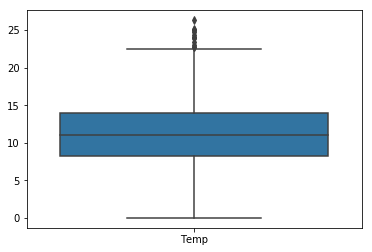

In [8]:
# checks for outliers
sb.boxplot(data=data)

In [9]:
from datetime import datetime
# converts to proper date time format
data['Date']=pd.to_datetime(data['Date'])
# convert into Time series object
data.set_index('Date', inplace=True)

In [10]:
data.index

DatetimeIndex(['1981-01-01', '1981-01-02', '1981-01-03', '1981-01-04',
               '1981-01-05', '1981-01-06', '1981-01-07', '1981-01-08',
               '1981-01-09', '1981-01-10',
               ...
               '1990-12-22', '1990-12-23', '1990-12-24', '1990-12-25',
               '1990-12-26', '1990-12-27', '1990-12-28', '1990-12-29',
               '1990-12-30', '1990-12-31'],
              dtype='datetime64[ns]', name='Date', length=3650, freq=None)

In [11]:
# removing outliers from the data
def remove_outlier(df):
    low = .05
    high = .95
    quant_df = df.quantile([low, high])
    for name in list(df.columns):
        if ptypes.is_numeric_dtype(df[name]):
            df = df[(df[name] > quant_df.loc[low, name]) & (df[name] < quant_df.loc[high, name])]
    return df

(3278, 1)

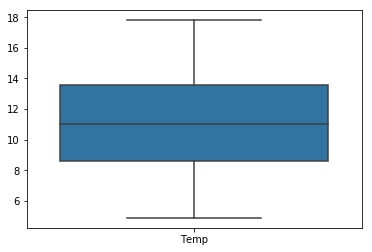

In [12]:
data= remove_outlier(data)
sb.boxplot(data=data)
data.shape


In [13]:
data=pd.DataFrame(data)
data.index 
type(data)

pandas.core.frame.DataFrame

In [14]:
type(data)

pandas.core.frame.DataFrame

In [15]:
# Feature scaling 
# to normalize data in the (0, 1) interval.
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
ts = scaler.fit_transform(data)


In [16]:
ts=pd.DataFrame(ts)
# ts.index 
type(ts)


pandas.core.frame.DataFrame

In [17]:
#converted to time series:
ts = data['Temp']
ts.head(10)

Date
1981-01-04    14.6
1981-01-05    15.8
1981-01-06    15.8
1981-01-07    15.8
1981-01-08    17.4
1981-01-11    16.2
1981-01-12    13.3
1981-01-13    16.7
1981-01-19    17.7
1981-01-20    15.5
Name: Temp, dtype: float64

In [18]:
#1. Specific the index as a string constant:
ts['1981-01-08']

17.4

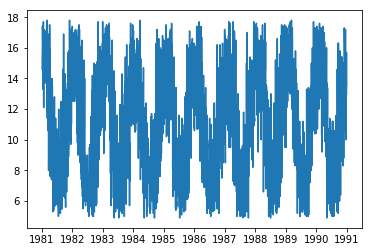

In [19]:
plt.plot(ts)

Stationarity testing

In [20]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()

    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

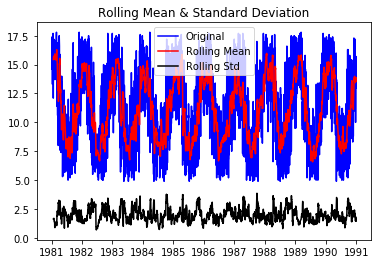

Results of Dickey-Fuller Test:
Test Statistic                   -4.080265
p-value                           0.001044
#Lags Used                       24.000000
Number of Observations Used    3253.000000
Critical Value (1%)              -3.432362
Critical Value (5%)              -2.862429
Critical Value (10%)             -2.567243
dtype: float64


In [21]:
test_stationarity(ts)

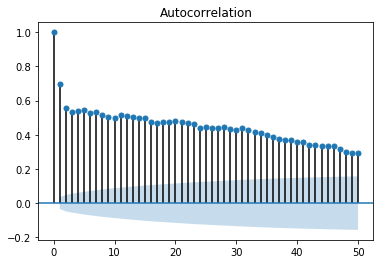

In [22]:
from matplotlib import pyplot
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(ts,lags=50)
pyplot.show()

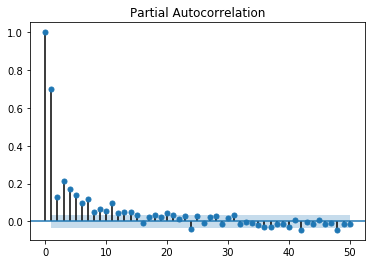

In [23]:
from matplotlib import pyplot
from statsmodels.graphics.tsaplots import plot_pacf

plot_pacf(ts, lags=50)
pyplot.show()

In [24]:
import sklearn
from sklearn.model_selection import train_test_split

# splitting data into train & test dataset
train,test=train_test_split(ts,test_size=0.3)

In [25]:
train.head()
train.shape

(2294,)

In [26]:
# evaluate an ARIMA model for a given order (p,d,q)
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_absolute_error

def evaluate_arima_model(X, arima_order):
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    error = mean_absolute_error(test, predictions)
    return error

In [27]:
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mse = evaluate_arima_model(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s MSE=%.3f' % (order,mse))
                except:
                    continue
    print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))

In [31]:
# evaluate parameters
p_values = [5, 1]
d_values = range(0, 2)
q_values = range(0, 2)
warnings.filterwarnings("ignore")
evaluate_models(ts.values, p_values, d_values, q_values)

ARIMA(5, 0, 0) MSE=2.723
ARIMA(5, 1, 0) MSE=2.884
ARIMA(1, 0, 0) MSE=2.722
ARIMA(1, 1, 0) MSE=3.237
Best ARIMA(1, 0, 0) MSE=2.722


In [30]:
from sklearn.metrics import mean_absolute_error

# X = data
# size = int(len(X) * 0.66)
# train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()


for t in range(len(test)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_absolute_error(test, predictions)
print('Test MSE: %.3f' % error)


predicted=14.128676, expected=14.000000
predicted=14.972373, expected=6.900000
predicted=13.546351, expected=11.200000
predicted=12.650226, expected=10.400000
predicted=12.251869, expected=10.900000
predicted=11.051293, expected=8.600000
predicted=10.367356, expected=13.800000
predicted=10.343455, expected=14.500000
predicted=11.617976, expected=11.000000
predicted=11.438901, expected=15.500000
predicted=12.479705, expected=6.900000
predicted=11.433445, expected=15.500000
predicted=13.046243, expected=11.800000
predicted=12.527993, expected=8.000000
predicted=11.323033, expected=10.500000
predicted=11.495922, expected=12.500000
predicted=10.815493, expected=9.200000
predicted=11.266729, expected=10.500000
predicted=10.473753, expected=6.300000
predicted=9.351403, expected=7.800000
predicted=9.476502, expected=8.100000
predicted=9.132151, expected=13.900000
predicted=9.443089, expected=12.000000
predicted=9.794760, expected=9.000000
predicted=9.382260, expected=11.800000
predicted=10.43